In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandana
import pandas as pd
from shapely.geometry import Point

In [25]:
#Prepare the graph
walk_speed = 4.8  # km per hour (3mph)
walk_time = 20

project_site = (33.9379368079315, -118.25653793837309)
latlng_point = Point(project_site[1], project_site[0])

latlng_point_proj, crs = ox.projection.project_geometry(latlng_point) #projected in meters (UTM)
polygon_proj = latlng_point_proj.buffer(4820) #do meaningful operations in the meter projection
polygon, crs = ox.projection.project_geometry(polygon_proj, crs=crs, to_latlong=True) #reproject to latlong

G_walk = ox.graph_from_polygon(polygon, network_type='walk', truncate_by_edge=True)

# set a uniform walking speed on every edge
for u, v, data in G_walk.edges(data=True):
    data['speed_kph'] = walk_speed
G_walk = ox.add_edge_travel_times(G_walk)

# extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(G_walk, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(G_walk, nodes=False).reset_index()[['u', 'v', 'travel_time']]

C:\Users\Ryan\.conda\envs\final\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Ryan\.conda\envs\final\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Ryan\.conda\envs\final\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\Ryan\.conda\envs\final\lib\site-packages\pandana\network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\Ryan\.conda\envs\final\lib\site-packages\pandana\network.py:668: DeprecationW

True

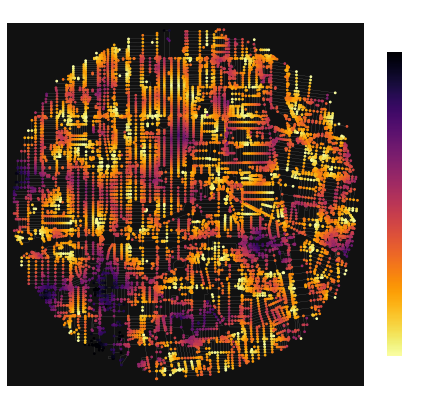

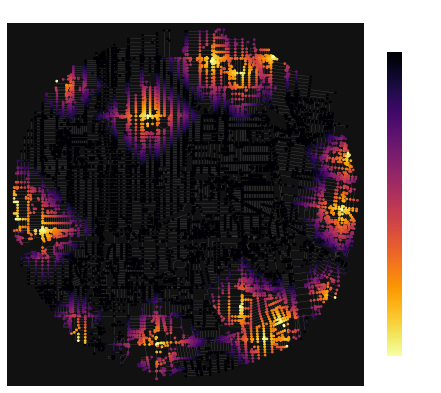

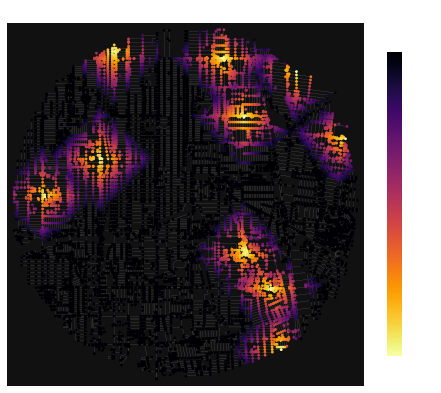

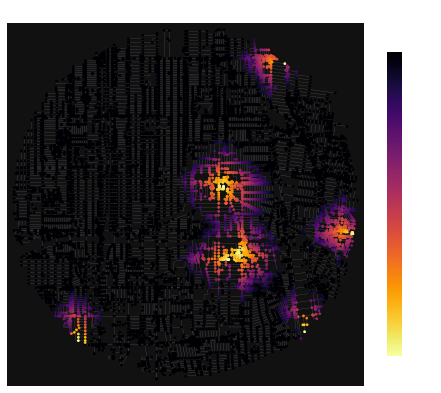

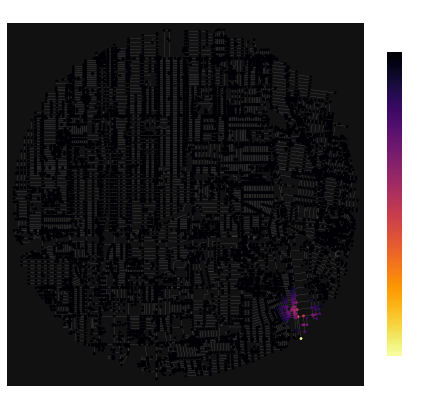

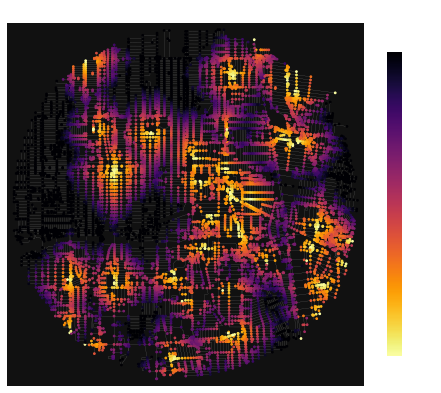

In [41]:
# tags = {'food_store':{'shop': ['grocery', 'greengrocer', 'supermarket', 'convenience']}
#         }

tags = {'school':{'amenity': ['school', 'kindergarten']},
        'grocery_store':{'shop': ['grocery', 'greengrocer', 'supermarket', 'convenience']},
        'library':{'amenity':['library']},
        'healthcare_facility':{'amenity':['clinic','hospital','doctors']},
        'pharmacy':{'amenity':['pharmacy']},
        'bank_or_ATM':{'amenity':['bank','atm']},
        'park':{'leisure':['park']}
        }

#tags is a dict of dicts
def amenity_map(tags, G=G_walk, walk_time=walk_time):
    for name, tag_dict in tags.items():
        amenities = ox.geometries_from_bbox(north=nodes['y'].max(),
                                            south=nodes['y'].min(),
                                            east=nodes['x'].min(),
                                            west=nodes['x'].max(),
                                            tags=tag_dict)
        if len(amenities) != 0:
            # construct the pandana network model
            network = pandana.Network(node_x=nodes['x'],
                                    node_y=nodes['y'], 
                                    edge_from=edges['u'],
                                    edge_to=edges['v'],
                                    edge_weights=edges[['travel_time']])

            # extract (approximate, unprojected) centroids from the amenities' geometries
            centroids = amenities.centroid

            # specify a max travel distance for this analysis
            # then set the amenities' locations on the network
            maxdist = walk_time * 60  # minutes -> seconds, to match travel_time units
            network.set_pois(category=name,
                            maxdist=maxdist,
                            maxitems=3,
                            x_col=centroids.x, 
                            y_col=centroids.y)
            
            # calculate travel time to nearest amenity from each node in network
            distances = network.nearest_pois(distance=maxdist,
                                            category=name,
                                            num_pois=3)
            
            # plot distance to nearest amenity

            plt.ioff()
            plt.style.use('dark_background')

            fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.1,
                                    edge_color='gray', show=False, close=False)

            sc = ax.scatter(x=nodes['x'],
                            y=nodes['y'], 
                            c=distances[1],
                            s=3,
                            cmap='inferno_r') #inferno goes all the way down to black, unlike plasma

            try:
                formatted_name = name.replace('_', ' ')
            except:
                formatted_name = name
            
            fig.patch.set_facecolor('#111111')

            ax.set_title(f'Walking time to nearest {formatted_name} (seconds)')
            plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')
            plt.savefig(f'figures/access_{name}.png', bbox_inches='tight',dpi=400, facecolor='#111111')

            plt.ioff()

    return(True)
        
amenity_map(tags)